# 3D Structure Function Data with UCAR LES

This example will guide you through each step necessary to compute Longitudinal SFs from UCAR-LES Data

$\textbf{General procedure}:$


    1 -  Load 3D UCAR-LES (with turbines dataset), dataset can be made available upon reasonable request
    2 -  Format dataset 
    3 -  Compute 3D longitudinal SF
    4 -  Plot 3D longitudinal SF
    5 -  Compute Isotropic SF
    6 -  Plot Isotropic SF

Note: To capture meaningful Structure functions in 3D, the vertical coordinate should  be stretched as 

$z^{*} = \int_{0}^{z} \frac{\overline{N}}{f} dz^{'}$ where N is derived from the 3D Brunt-Vaisala frequency and f is the Coriolis parameter

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
import matplotlib.ticker as ticker
import pyturbo_sf as psf
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

linewidth = 2
fontsize = 12
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['savefig.dpi'] = 150
plt.rc('font', family='serif')
import gc

# Load Dataset

In [2]:
path = '/glade/derecho/scratch/aayouche/LES_outputs/with_wind_farms/'
ds_b = xr.open_dataset(path+'buoyancy.7012.nc').rename({'xt': 'x', 'yt': 'y', 'zt': 'z'})
ds_u = xr.open_dataset(path+'u.7012.nc').rename({'xm': 'x', 'yt': 'y', 'zt': 'z'}).interp(x=ds_b.x)
ds_v = xr.open_dataset(path+'v.7012.nc').rename({'xt': 'x', 'ym': 'y', 'zt': 'z'}).interp(y=ds_b.y)
ds_w = xr.open_dataset(path+'w.7012.nc').rename({'xt': 'x', 'yt': 'y', 'zm': 'z'}).interp(z=ds_b.z)
x = ds_u.x + ds_u.x.max()
y = ds_u.y + ds_u.y.max()
z = ds_v.z
N = (xr.apply_ufunc(np.abs,ds_b.buoyancy.differentiate('z').transpose('z','y','x'),dask='parallelized')**0.5).mean(('y','x'))
f = 1.0e-4
u = ds_u['u'].transpose('z','y','x')
v = ds_v['v'].transpose('z','y','x')
w = ds_w['w'].transpose('z','y','x')
y_coord = y.expand_dims({'z': len(z), 'x': len(x)}).transpose('z','y','x').drop_vars('y')
x_coord = x.expand_dims({'z': len(z), 'y': len(y)}).transpose('z','y','x').drop_vars('x')

# Compute $Z^{\star}$

In [4]:


def calculate_stretched_coordinate_1D(z_coord, N_field, f_scalar, surface_at_top=True):
    """
    Calculate the stretched coordinate Z* = ∫(N/f)dz' between free surface (eta) and z
    Optimized for case where:
    - z_coord is 1D (varies only with depth)
    - N_field is 1D (varies only with depth)
    - f_scalar is a constant scalar value
    
    Parameters:
    -----------
    z_coord : xarray.DataArray
        The 1D z-coordinate array with dimension 'z'
    N_field : xarray.DataArray
        The 1D Brunt-Väisälä frequency array with dimension 'z'
    f_scalar : float or xarray.DataArray with single value
        The Coriolis parameter as a scalar
    surface_at_top : bool, optional
        If True, assumes the free surface (eta) is at z_coord[0]
        If False, assumes the free surface is at z_coord[-1]
        
    Returns:
    --------
    Z_star : xarray.DataArray
        The 1D stretched coordinate array with dimension 'z'
    """
    # Convert everything to numpy arrays for calculation
    z_values = z_coord.values
    N_values = N_field.values
    f_value = float(f_scalar)  # Ensure it's a scalar
    
    # Calculate N/f directly - no need for loops
    N_over_f = N_values / f_value
    
    # Create output array
    Z_star_values = np.zeros_like(z_values)
    
    # Determine surface index
    surface_idx = 0 if surface_at_top else len(z_values) - 1
    
    # For each depth level, integrate from surface to that depth
    for k in range(len(z_values)):
        if k == surface_idx:
            Z_star_values[k] = 0.0
        else:
            if surface_at_top:
                # Integrate downward from surface
                if k > surface_idx:
                    z_section = z_values[surface_idx:k+1]
                    Nf_section = N_over_f[surface_idx:k+1]
                    Z_star_values[k] = np.trapz(Nf_section, z_section)
                else:
                    z_section = z_values[k:surface_idx+1]
                    Nf_section = N_over_f[k:surface_idx+1]
                    Z_star_values[k] = -np.trapz(Nf_section, z_section)
            else:
                # Integrate upward from depth to surface
                if k < surface_idx:
                    z_section = z_values[k:surface_idx+1]
                    Nf_section = N_over_f[k:surface_idx+1]
                    Z_star_values[k] = np.trapz(Nf_section, z_section)
                else:
                    z_section = z_values[surface_idx:k+1]
                    Nf_section = N_over_f[surface_idx:k+1]
                    Z_star_values[k] = -np.trapz(Nf_section, z_section)
    
    # Create xarray DataArray with the same dimension and coordinates as z_coord
    Z_star = xr.DataArray(
        Z_star_values,
        dims=z_coord.dims,
        coords=z_coord.coords,
        attrs={'long_name': 'Stretched coordinate Z*', 
               'units': 'm',
               'description': 'Stretched coordinate Z* = ∫(N/f)dz\''}
    )
    
    return Z_star

# First compute the 1D stretched coordinate
Z_star_1D = calculate_stretched_coordinate_1D(
    z_coord=z,  # Your 1D z-coordinate 
    N_field=N,        # Your 1D N profile
    f_scalar=f,       # Your scalar f value
    surface_at_top=True
)

z_coord = Z_star_1D.expand_dims({'y': len(y), 'x': len(x)}).transpose('z','y','x').drop_vars('z')


# Format Dataset

In [5]:
ds = xr.Dataset(
    data_vars={
        'u': u,  # These are DataArrays - correct usage
        'v': v,
        'w': w
    },
    coords={
        'z': z_coord,  # These are your coordinate DataArrays
        'y': y_coord,
        'x': x_coord
    }
)


In [6]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:  (z: 100, y: 1200, x: 1200)
Coordinates:
    z        (z, y, x) float32 576MB 0.0 0.0 0.0 ... 1.833e+04 1.833e+04
    y        (z, y, x) float64 1GB 0.0 0.0 0.0 ... 1.199e+04 1.199e+04 1.199e+04
    x        (z, y, x) float64 1GB 0.0 10.0 20.0 ... 1.198e+04 1.199e+04
Data variables:
    u        (z, y, x) float32 576MB 2.633 2.667 2.714 ... 8.373 8.379 8.389
    v        (z, y, x) float32 576MB 0.3825 0.4213 0.4294 ... 6.539 6.545 6.522
    w        (z, y, x) float32 576MB -0.01788 -0.0334 ... -0.007382 -0.005415

# Calculate 3D Longitudinal SF

In [9]:
bins = {
    'x': np.logspace(np.log10(10.0), np.log10(10.0e3), 12),
    'y': np.logspace(np.log10(10.0), np.log10(10.0e3), 12),
    'z': np.logspace(np.log10(632.), np.log10(18.0e3), 9),
}
sf_result = psf.bin_sf_3d(
    ds=ds,
    variables_names=["u","v","w"],
    order=2,
    bins=bins,
    fun='longitudinal',
    bootsize={'z':100,'y':8,'x':8},
    initial_nbootstrap=30,
    max_nbootstrap=60,
    step_nbootstrap=30,
    convergence_eps=1.5,
    n_jobs=64, # number of physical cores / change it to -1 if you want to use logical cores
)

Dimensions ['z', 'y', 'x'] are already in the expected order
Dimension z has bootsize equal to or larger than dimension size. No bootstrapping will be done across this dimension.
Using bootsize: {'z': 100, 'y': 8, 'x': 8}
Bootstrappable dimensions: ['y', 'x']
Two bootstrappable dimensions ['y', 'x']. Available spacings: [1, 2, 4, 8, 16, 32, 64, 128]

STARTING BIN_SF_3D WITH FUNCTION TYPE: longitudinal
Variables: ['u', 'v', 'w'], Order: 2
Bootstrap parameters: initial=30, max=60, step=30
Convergence threshold: 1.5
Bootstrappable dimensions: ['y', 'x'] (count: 2)

Bin dimensions: z=8, y=11, x=11
Total bins: 968
Bin type for x: logarithmic
Bin type for y: logarithmic
Bin type for z: logarithmic
Available spacings: [1, 2, 4, 8, 16, 32, 64, 128]

INITIAL BOOTSTRAP PHASE
  Processing spacing 1 with 5 bootstraps
  Processing spacing 2 with 5 bootstraps
  Processing spacing 4 with 5 bootstraps
  Processing spacing 8 with 5 bootstraps
  Processing spacing 16 with 5 bootstraps
  Processing spaci

# Plot 3D Longitudinal SF

In [65]:
def plot_sf_3d_box_custom(
        sf_result,
        cmap='jet',
        vmin=0.0,
        vmax=15.0,
        figsize=(12, 10),
        log_color=False,
        log_axes=False,
        z_offset=14e3,
        y_offset=1000,
        x_min=1000,
        y_min=1000,
        elev=30,
        azim=-45,
        corner_color='0.5',
        line_width=1.5,
        n_levels=60
    ):
    """
    Plot structure function in 3D with custom offsets and corner lines
    
    Parameters:
    -----------
    sf_result : xarray.Dataset
        The structure function result with 'sf' variable
    cmap : str, optional
        Colormap name (default: 'jet')
    vmin, vmax : float, optional
        Min/max values for colormap (default: 0.0, 1.0)
    figsize : tuple, optional
        Figure size (default: (12, 10))
    log_color : bool, optional
        Whether to use log scale for color (default: False)
    log_axes : bool, optional
        Whether to use log scales for axes (default: False)
    z_offset : float, optional
        Offset for the top face (default: 10e3)
    y_offset : float, optional
        Offset for the front face (default: 300)
    x_min : float, optional
        Minimum x value (default: 300)
    y_min : float, optional
        Minimum y value (default: 300)
    elev, azim : float, optional
        Elevation and azimuth for 3D view (default: 30, -45)
    corner_color : str, optional
        Color of corner lines (default: '0.5')
    line_width : float, optional
        Width of corner lines (default: 1.5)
    n_levels : int, optional
        Number of contour levels (default: 60)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Extract data
    array = sf_result.sf
    
    # Get slices for the three faces of the cube
    z_cut = array.isel(z=-1).values  # Top face
    x_cut = array.isel(x=-1).values  # Right face
    y_cut = array.isel(y=-1).values  # Back face
    # Determine global min/max across all faces for consistent colormap
    if vmin is None or vmax is None:
        all_data = np.concatenate([z_cut.flatten(), x_cut.flatten(), y_cut.flatten()])
        
        if log_color:
            # Filter out zeros and negative values for log scale
            all_data = all_data[all_data > 0]
            data_min = all_data.min() if len(all_data) > 0 else 1e-10
            data_max = array.values.max()
        else:
            data_min = all_data.min()
            data_max = all_data.max()
            
        vmin = vmin if vmin is not None else data_min
        vmax = vmax if vmax is not None else data_max
    
    # Get coordinates
    xx = sf_result.x.values
    yy = sf_result.y.values
    zz = sf_result.z.values
    print(zz[-1])
    # Create figure
    fig = plt.figure(figsize=figsize, dpi=120)
    ax = fig.add_subplot(111, projection='3d')
    
    # Create norm for colormap
    if log_color:
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = Normalize(vmin=vmin, vmax=vmax)
    
    # Create meshgrids for the three faces
    X, Y = np.meshgrid(xx, yy)
    Y_yz, Z_yz = np.meshgrid(yy, zz)
    X_xz, Z_xz = np.meshgrid(xx, zz)
    
    # Plot the three faces with custom offsets
    contour_kw = dict(
        levels=n_levels,
        cmap=cmap,
        norm=norm,
        antialiased=True,
        alpha=0.9,
        vmin=vmin,
        vmax=vmax
    )
    
    # Top face (xy plane at max z)
    cf1 = ax.contourf(X, Y, z_cut, zdir='z', offset=zz[-1], **contour_kw)
    
    # Right face (yz plane at max x)
    cf2 = ax.contourf(x_cut, Y_yz, Z_yz, zdir='x', offset=xx[-1], **contour_kw)
    
    # Front face (xz plane at custom y offset)
    cf3 = ax.contourf(X_xz, y_cut, Z_xz, zdir='y', offset=y_offset, **contour_kw)
    
    # Set custom axis limits
#    ax.set_zlim(4000, 14e3)
    ax.set_xlim(x_min, xx[-1])
    ax.set_ylim(y_min, yy[-1])
    
    # Apply log scale if requested
    if log_axes:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_zscale('log')
    
    
    # Set labels
    ax.set_xlabel(r'$r_x$ [m]', fontsize=12)
    ax.set_ylabel(r'$r_y$ [m]', fontsize=12)
    ax.set_zlabel(r'$r_z^{\star}$ [m]', fontsize=12)
    
    # Set view angle
    ax.view_init(elev=elev, azim=azim)
    
    # Add colorbar using the last contourf object
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(cf3, cax=cbar_ax)
    
    # Format the colorbar ticks for log scale
    if log_color:
        import matplotlib.ticker as ticker
        cbar.ax.yaxis.set_major_formatter(ticker.LogFormatterSciNotation(base=10.0))
    
    # Add colorbar label
    if hasattr(sf_result, 'attrs') and 'long_name' in sf_result.attrs:
        cbar.set_label(sf_result.attrs['long_name'], fontsize=12)
    else:
        cbar.set_label(r'$\delta u_{LL}~[m^{2}~s^{-2}]$', fontsize=12)
    
    # Set aspect ratio
    ax.set_box_aspect([1, 1, 0.7])
    
    # Remove grid lines for cleaner look
    ax.grid(False)
    
    # Improve overall layout
    fig.tight_layout(rect=[0, 0, 0.85, 1])
    
    return fig

14600.33400088331


/glade/derecho/scratch/aayouche/tmp/ipykernel_132686/911585812.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.85, 1])


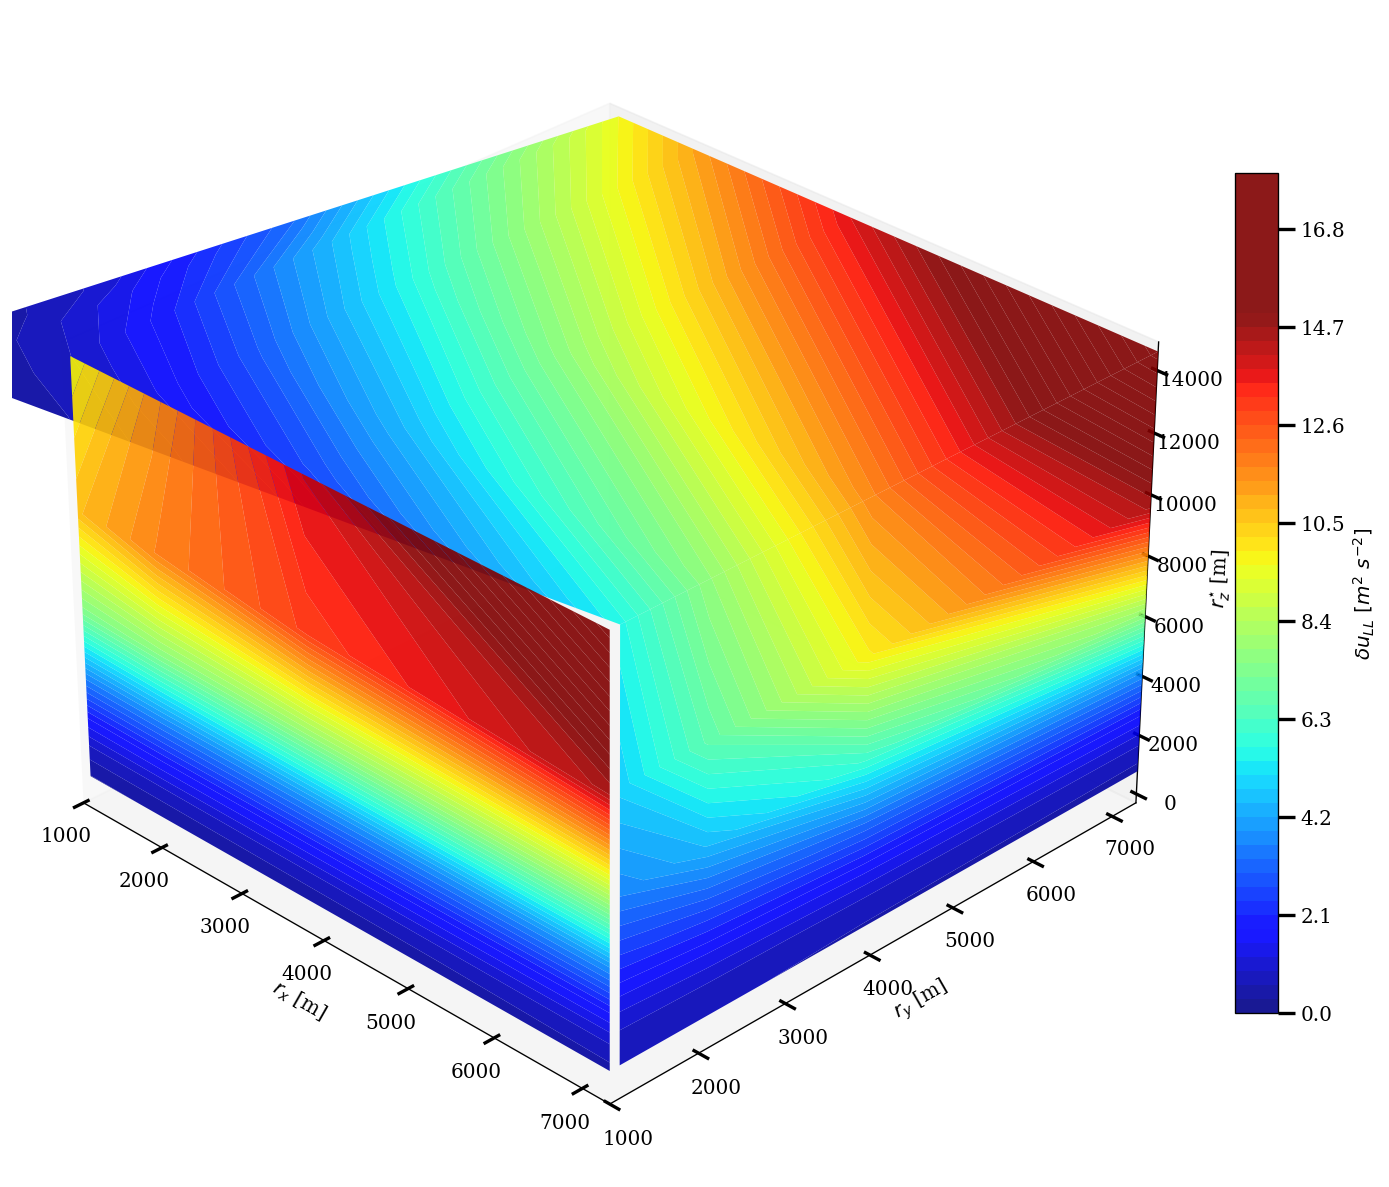

In [66]:
fig = plot_sf_3d_box_custom(sf_result)

# Compute 3D isotropic Longitudinal SF

In [82]:
# Define 21 logarithmically spaced radial bins 
r_bins = np.logspace(np.log10(632.0), np.log10(20.0e3), 21)  # 21 edges to make 20 bins

# Call the isotropic structure function
sf_iso_result = psf.get_isotropic_sf_3d(
    ds=ds,
    variables_names=["u", "v", "w"],
    order=2,
    bins={'r': r_bins},  # Pass radial bins as a dictionary with 'r' key
    bootsize={'z':100,'y':8,'x':8},        # Use a single value for all dimensions
    initial_nbootstrap=30,
    max_nbootstrap=60,
    step_nbootstrap=30,
    fun='longitudinal',
    n_bins_theta=36,     # Default is 36 - controls azimuthal angular bins
    n_bins_phi=18,       # Default is 18 - controls polar angular bins
    window_size_theta=12,  # Window size for isotropy error calculation
    window_size_phi=6,     # Window size for isotropy error calculation
    window_size_r=7,       # Window size for homogeneity error calculation
    convergence_eps=1.5,
    n_jobs=64
)

Dimensions ['z', 'y', 'x'] are already in the expected order
Dimension z has bootsize equal to or larger than dimension size. No bootstrapping will be done across this dimension.
Using bootsize: {'z': 100, 'y': 8, 'x': 8}
Bootstrappable dimensions: ['y', 'x']
Two bootstrappable dimensions ['y', 'x']. Available spacings: [1, 2, 4, 8, 16, 32, 64, 128]

STARTING ISOTROPIC_SF_3D WITH FUNCTION TYPE: longitudinal
Variables: ['u', 'v', 'w'], Order: 2
Bootstrap parameters: initial=30, max=60, step=30
Convergence threshold: 1.5
Bootstrappable dimensions: ['y', 'x'] (count: 2)

Detected logarithmic binning for radial dimension
Using 20 radial bins, 36 azimuthal bins, and 18 polar bins
Using window size 12 for theta, 6 for phi, and 7 for r
Available spacings: [1, 2, 4, 8, 16, 32, 64, 128]

INITIAL BOOTSTRAP PHASE
  Processing spacing 1 with 5 bootstraps
  Processing spacing 2 with 5 bootstraps
  Processing spacing 4 with 5 bootstraps
  Processing spacing 8 with 5 bootstraps
  Processing spacing 1

# plot 3D isotropic Longitudinal SF

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:63: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:63: SyntaxWarning: invalid escape sequence '\d'
/glade/derecho/scratch/aayouche/tmp/ipykernel_132686/2392156009.py:5: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(iso_sf_lon.r, iso_sf_lon.sf, 'b-', linewidth=2.5, label='Longitudinal Structure Function'+' '+'$\delta u_{LL}$')
/glade/derecho/scratch/aayouche/tmp/ipykernel_132686/2392156009.py:43: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(iso_sf_lon.r, iso_sf_lon.error_isotropy, 'b-', linewidth=2.5,label='Longitudinal Structure Function'+' '+'$\delta u_{LL}$')
/glade/derecho/scratch/aayouche/tmp/ipykernel_132686/2392156009.py:63: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(iso_sf_lon.r_subset, iso_sf_lon.error_homogeneity, 'b-', linewidth=2.5,label='Long

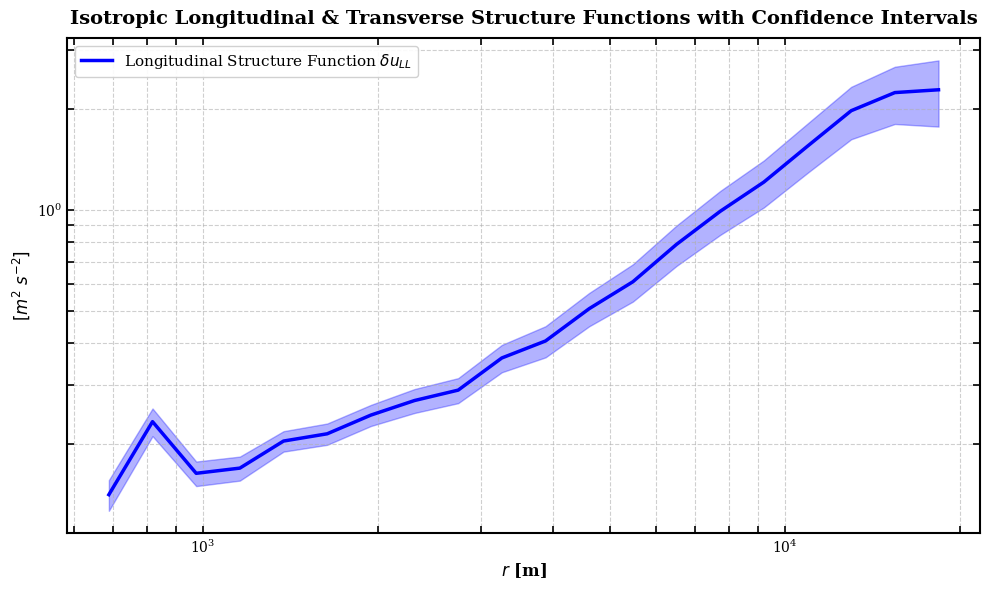

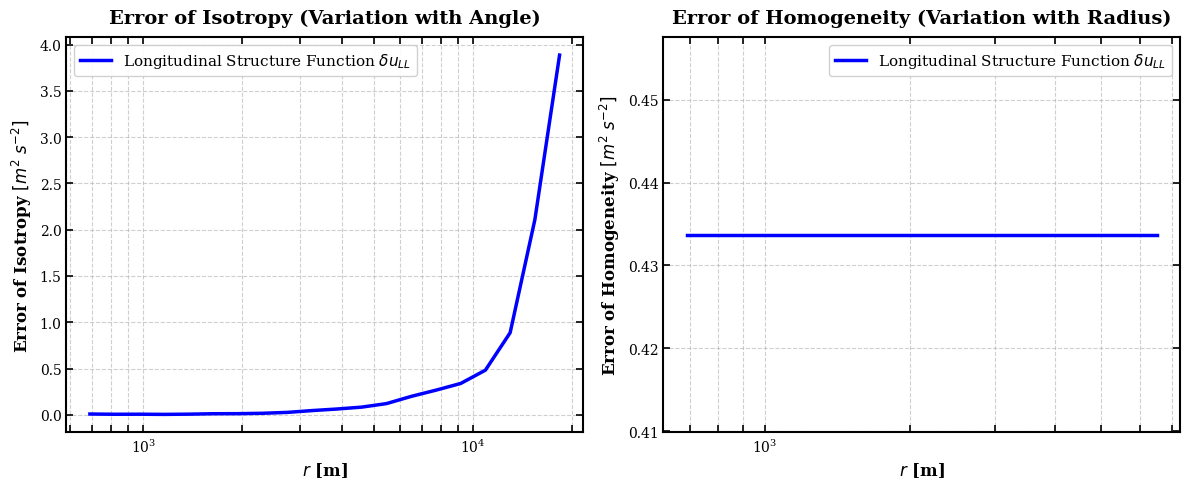

In [84]:
iso_sf_lon = sf_iso_result
# Create separate figures for better spacing and clarity
plt.figure(figsize=(10, 6))
# Structure Function with Confidence Interval
plt.plot(iso_sf_lon.r, iso_sf_lon.sf, 'b-', linewidth=2.5, label='Longitudinal Structure Function'+' '+'$\delta u_{LL}$')

plt.fill_between(iso_sf_lon.r, 
                iso_sf_lon.ci_lower, 
                iso_sf_lon.ci_upper, 
                alpha=0.3, color='blue')


# Formatting
plt.xlabel(r'$r$ [m]', fontsize=12, fontweight='bold')
plt.ylabel(r'$[m^{2}~s^{-2}]$', fontsize=12, fontweight='bold')
plt.title('Isotropic Longitudinal & Transverse Structure Functions with Confidence Intervals', 
         fontsize=14, fontweight='bold', pad=10)
plt.legend(fontsize=11, frameon=True, facecolor='white', framealpha=0.9)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.yscale('log')
plt.xscale('log')

# Customize spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Customize tick parameters
ax.tick_params(which='both', direction='in', width=1.2, length=5, 
              labelsize=10, top=True, right=True)
ax.xaxis.set_major_formatter(ticker.LogFormatterSciNotation())

plt.tight_layout()


# --------------------------------------------------
# Errors of Isotropy and Homogeneity
# --------------------------------------------------
plt.figure(figsize=(12, 5))

# Error of isotropy
plt.subplot(121)
plt.plot(iso_sf_lon.r, iso_sf_lon.error_isotropy, 'b-', linewidth=2.5,label='Longitudinal Structure Function'+' '+'$\delta u_{LL}$')

plt.xlabel(r'$r$ [m]', fontsize=12, fontweight='bold')
plt.ylabel('Error of Isotropy'+' '+r'$[m^{2}~s^{-2}]$', fontsize=12, fontweight='bold')
plt.title('Error of Isotropy (Variation with Angle)', 
         fontsize=14, fontweight='bold', pad=10)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.xscale('log')
plt.legend(fontsize=11, frameon=True, facecolor='white', framealpha=0.9)

# Customize spines and ticks
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.tick_params(which='both', direction='in', width=1.2, length=5, 
              labelsize=10, top=True, right=True)
ax.xaxis.set_major_formatter(ticker.LogFormatterSciNotation())

# Error of homogeneity
plt.subplot(122)
plt.plot(iso_sf_lon.r_subset, iso_sf_lon.error_homogeneity, 'b-', linewidth=2.5,label='Longitudinal Structure Function'+' '+'$\delta u_{LL}$')
plt.xlabel(r'$r$ [m]', fontsize=12, fontweight='bold')
plt.ylabel('Error of Homogeneity'+' '+r'$[m^{2}~s^{-2}]$', fontsize=12, fontweight='bold')
plt.title('Error of Homogeneity (Variation with Radius)', 
         fontsize=14, fontweight='bold', pad=10)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.xscale('log')
plt.legend(fontsize=11, frameon=True, facecolor='white', framealpha=0.9)

# Customize spines and ticks
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.tick_params(which='both', direction='in', width=1.2, length=5, 
              labelsize=10, top=True, right=True)
ax.xaxis.set_major_formatter(ticker.LogFormatterSciNotation())

plt.tight_layout()

plt.show()


# Plot Spherical

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_sf_spherical(sf_iso_result, r_idx=None, figsize=(10, 10)):
    """
    Plot the spherical structure function as a 3D sphere.
    
    Parameters:
    -----------
    sf_iso_result : xarray.Dataset
        The isotropic structure function result with sf_spherical data
    r_idx : int or None
        Index of the radius to plot. If None, uses the middle radius.
    figsize : tuple
        Figure size
    """
    # Extract the data
    sf_spherical = sf_iso_result.sf_spherical.values  # Shape: (phi, theta, r)
    phi_vals = sf_iso_result.phi.values
    theta_vals = sf_iso_result.theta.values
    r_vals = sf_iso_result.r.values
    
    n_r = len(r_vals)
    
    if r_idx is None:
        # If no r_idx provided, default to middle radius
        r_idx = n_r // 2
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Create the mesh grid for the sphere
    phi_mesh, theta_mesh = np.meshgrid(phi_vals, theta_vals, indexing='ij')
    
    # Get the SF data for this radius
    sf_r = sf_spherical[:, :, r_idx]
    
    # Normalize for color mapping
    sf_min = np.nanmin(sf_r)
    sf_max = np.nanmax(sf_r)
    
    if np.isnan(sf_min) or np.isnan(sf_max) or sf_min == sf_max:
        print(f"Warning: Invalid data range at r_idx={r_idx}, r={r_vals[r_idx]:.2f} m")
        sf_norm = np.zeros_like(sf_r)
    else:
        sf_norm = (sf_r - sf_min) / (sf_max - sf_min)
    
    # Convert spherical to Cartesian coordinates
    # Note: In physics convention, phi is polar angle (0 to π) and theta is azimuthal (0 to 2π)
    X = np.sin(phi_mesh) * np.cos(theta_mesh)
    Y = np.sin(phi_mesh) * np.sin(theta_mesh)
    Z = np.cos(phi_mesh)
    
    # Create colormapped surface
    cmap = plt.get_cmap('jet')
    colors = cmap(sf_norm)
    
    surf = ax.plot_surface(
        X, Y, Z, 
        facecolors=colors,
        rstride=1, cstride=1, 
        linewidth=0, antialiased=True, alpha=0.8
    )
    
    # Add colorbar
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(sf_r)
    cbar = plt.colorbar(m, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Structure Function [m²/s²]')
    
    # Set plot properties
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Spherical Structure Function at r = {r_vals[r_idx]:.2f} m')
    
    # Equal aspect ratio
    ax.set_box_aspect([1,1,1])
    
    # Set viewing angle
    ax.view_init(elev=30, azim=45)
    
    return fig, ax

# Example usage:
# fig, ax = plot_sf_spherical(sf_iso_result, r_idx=10)
# plt.show()

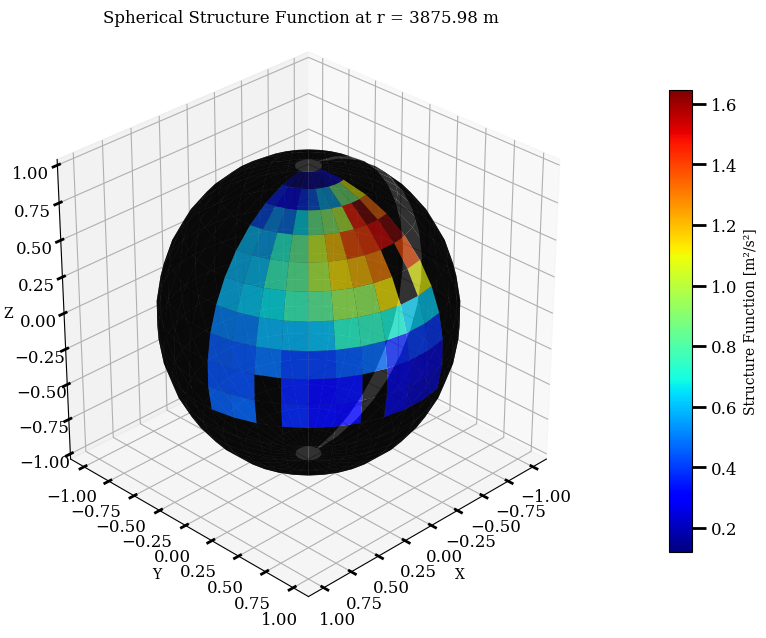

In [111]:
# Plot for a specific radius index (e.g., the 10th radius bin)
fig, ax = plot_sf_spherical(sf_iso_result, r_idx=10)
plt.show()